# Deep Learning Review & More

## CIFAR-10

### Your name :

#### 실습목표<br>
1. ANN의 기본 아이디어를 복습한다.
6. Early Stopping 기능을 복습한다.
3. keras를 이용하여 Dropout이 가능하다.
5. keras를 이용하여 Batch Normalization이 가능하다.

--------------------------

## Deep Learning on CIFAR-10

### Library Loading

In [1]:
'''
라이브러리들을 불러오자.
'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

import random as rd
from sklearn.metrics import accuracy_score

### Data Loading & Preparation

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 3s 0us/step


In [3]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


In [4]:
labels = { 0 : 'Airplane',
          1 : 'Automobile',
          2 : 'Bird',
          3 : 'Cat',
          4 : 'Deer',
          5 : 'Dog',
          6 : 'Frog',
          7 : 'Horse',
          8 : 'Ship',
          9 : 'Truck' }

print(labels)

{0: 'Airplane', 1: 'Automobile', 2: 'Bird', 3: 'Cat', 4: 'Deer', 5: 'Dog', 6: 'Frog', 7: 'Horse', 8: 'Ship', 9: 'Truck'}


id = 1091
다음 그림은 Ship 입니다.


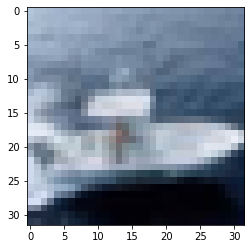

In [5]:
'''
Ctrl+Enter를 이용하여
반복 실행 해보자!
'''

id = rd.randrange(0,10000)

print('id = {}'.format(id))
print('다음 그림은 {} 입니다.'.format( labels[y_test[id][0]] ))
plt.imshow(x_test[id])
plt.show()

# Q1. 이미지를 전부 Standardization할 것.

* Standardization :  x <-- (x - mean)/std
* **모든 전처리 규칙은 트레이닝 셋을 바탕으로 한다.**

In [6]:
####################
## Your code here ##
####################

# 트레이닝셋을 바탕으로 평균값을 미리 계산하여 선언해둔다.
mean_ = x_train.mean()
# 트레이닝셋을 바탕으로 표준편차값을 미리 계산하여 선언해둔다.
std_ = x_train.std()
# 스케일링 규칙에 따라, x_train과 x_test를 전부 표준화 한다.
x_train = ( x_train - mean_   ) / ( std_  )
x_test = ( x_test - mean_ ) / ( std_ )
# 효과 :  데이터의 평균을 0으로 세팅해주고, 표준편차를 1로 세팅해준다.
# 주의 : 정규분포를 만드는 것은 아니다!
# 이후 공부포인트 : 평균을 0으로 맞춰주는 것이, 최적화 관점에서 어떤 의미가 생길까?


# Q2. y를 전부 원핫 인코딩 할 것.

In [7]:
####################
## Your code here ##
####################

# 라이브러리에서 어떤 함수를 불러오는 코드와
# 그 함수를 사용하는 코드가 하나의 셀에 동시에 있을 때는
# 함수를 불러오는 코드를 작성한 직후, 컨트롤+엔터를 눌러서 한번 실행해주면
# 자동완성에 도움이 됨!

from tensorflow.keras.utils import to_categorical
print(y_train.shape, y_test.shape)
y_train, y_test = to_categorical(y_train), to_categorical(y_test)
print(y_train.shape, y_test.shape)

(50000, 1) (10000, 1)
(50000, 10) (10000, 10)


# Q3. 모델링 할 것.

**모델구조는 아래와 같다.**
1. 적절한 인풋레이어
2. 적절히 reshape를 하는 레이어
3. Fully Connected, 2048, swish
3. Fully Connected, 2048, swish
3. Fully Connected, 2048, swish
4. 적절한 아웃풋레이어


In [8]:
## 필요한 라이브러리 불러오기
from tensorflow.keras.layers import Input, Flatten, Dense

In [9]:
## 주석 부터 짜는 습관을 !
# 세션날리기
tf.keras.backend.clear_session()
## 모델 구조를 코딩
# 모델 발판 (시퀀셜 준비)
model = tf.keras.models.Sequential()
# 모델에 레이어 블럭을 결합
# 적절한 인풋레이어 : shape : 32, 32, 3
model.add(Input(shape=(32,32,3)))
# 플래튼
model.add(Flatten())
# Fully Connected, 2048, swish
model.add(Dense( 2048, activation='swish'))
# Fully Connected, 2048, swish
model.add(Dense( 2048, activation='swish'))
# Fully Connected, 2048, swish
model.add(Dense( 2048, activation='swish'))
# 적절한 아웃풋레이어, 클래스 개수가 10개 였음.
model.add(Dense(10, activation='softmax'))

# 나 모델 다 만들었음 (컴파일)
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics=['accuracy'])

# Q4. 모델 학습시킬 것.

1. 얼리스토핑한다.
    - 7번 이내 개선되어야함.
    - 얼리스토핑 후, 가장 성능 좋았던 모델로 복구
2. 학습
    - 배치사이즈 : 512
    - epochs : 10000
    - 학습데이터의 15%를 벨리데이션 셋으로 둔다.
3. 테스트셋에서의 accuracy를 출력한다.

In [10]:
####################
## Your code here ##
####################
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', # 벨리데이션 로스를 모니터링 하고 있다가.
                   min_delta=0, # (성능이 악화되지만 않으면 돼)
                   patience=7, # 7번 이내로 개선이 되지 않으면 멈춰!
                   verbose=1, # 멈췄을때 사유 출력
                   restore_best_weights=True) # 가장 성능 좋았던 epoch때의 모델 복원

model.fit(x_train, y_train, epochs=10000,
          batch_size=512, validation_split=0.15, callbacks=[es])

print(model.evaluate(x_test, y_test))

Epoch 1/10000
84/84 [==============================] - 6s 38ms/step - loss: 1.9821 - accuracy: 0.3612 - val_loss: 1.7344 - val_accuracy: 0.4008
Epoch 2/10000
84/84 [==============================] - 3s 33ms/step - loss: 1.5002 - accuracy: 0.4650 - val_loss: 1.5429 - val_accuracy: 0.4476
Epoch 3/10000
84/84 [==============================] - 3s 31ms/step - loss: 1.3251 - accuracy: 0.5238 - val_loss: 1.6081 - val_accuracy: 0.4560
Epoch 4/10000
84/84 [==============================] - 3s 32ms/step - loss: 1.3017 - accuracy: 0.5363 - val_loss: 1.6478 - val_accuracy: 0.4424
Epoch 5/10000
84/84 [==============================] - 3s 34ms/step - loss: 1.1493 - accuracy: 0.5884 - val_loss: 1.3838 - val_accuracy: 0.5231
Epoch 6/10000
84/84 [==============================] - 3s 31ms/step - loss: 0.9268 - accuracy: 0.6704 - val_loss: 1.5689 - val_accuracy: 0.5027
Epoch 7/10000
84/84 [==============================] - 3s 32ms/step - loss: 0.8559 - accuracy: 0.6969 - val_loss: 1.6895 - val_accuracy:

# Q5. 모델링 할 것.

**모델구조는 아래와 같다.**
1. 적절한 인풋레이어
2. 적절히 reshape를 하는 레이어
3. Fully Connected, 2048, swish
3. BatchNormalization
4. Dropout, droprate : 25%
3. Fully Connected, 2048, swish
3. BatchNormalization
4. Dropout, droprate : 25%
3. Fully Connected, 2048, swish
4. 적절한 아웃풋레이어

참고
1. [드랍 아웃](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/04/1IrdJ5PghD9YoOyVAQ73MJw.gif)
2. [배치 노말라이제이션](https://gaussian37.github.io/assets/img/dl/concept/batchnorm/4.png)


In [15]:
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout

In [16]:
## 주석 부터 짜는 습관을 !
# 세션날리기
tf.keras.backend.clear_session()
## 모델 구조를 코딩
# 모델 발판 (시퀀셜 준비)
model = tf.keras.models.Sequential()
# 모델에 레이어 블럭을 결합
# 적절한 인풋레이어 : shape : 32, 32, 3
model.add(Input(shape=(32,32,3)))
# 플래튼
model.add(Flatten())
# Fully Connected, 2048, swish
model.add(Dense( 2048, activation='swish'))
# 배치놈!
model.add(BatchNormalization())
# 드랍아웃! 25%
model.add(Dropout(0.25))
# Fully Connected, 2048, swish
model.add(Dense( 2048, activation='swish'))
# 배치놈!
model.add(BatchNormalization())
# 드랍아웃! 25%
model.add(Dropout(0.25))
# Fully Connected, 2048, swish
model.add(Dense( 2048, activation='swish'))
# 적절한 아웃풋레이어, 클래스 개수가 10개 였음.
model.add(Dense(10, activation='softmax'))

# 나 모델 다 만들었음 (컴파일)
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics=['accuracy'])

# Q6. 모델 학습시킬 것.

1. 얼리스토핑한다.
    - 7번 이내 개선되어야함.
    - 얼리스토핑 후, 가장 성능 좋았던 모델로 복구
2. 학습
    - 배치사이즈 : 512
    - epochs : 10000
    - 학습데이터의 15%를 벨리데이션 셋으로 둔다.
3. 테스트셋에서의 accuracy를 출력한다.

In [17]:
####################
## Your code here ##
####################
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', # 벨리데이션 로스를 모니터링 하고 있다가.
                   min_delta=0, # (성능이 악화되지만 않으면 돼)
                   patience=7, # 7번 이내로 개선이 되지 않으면 멈춰!
                   verbose=1, # 멈췄을때 사유 출력
                   restore_best_weights=True) # 가장 성능 좋았던 epoch때의 모델 복원

model.fit(x_train, y_train, epochs=10000,
          batch_size=512, validation_split=0.15, callbacks=[es])

print(model.evaluate(x_test, y_test))

Epoch 1/10000
84/84 [==============================] - 5s 42ms/step - loss: 2.2421 - accuracy: 0.3398 - val_loss: 3.0707 - val_accuracy: 0.2873
Epoch 2/10000
84/84 [==============================] - 3s 36ms/step - loss: 1.7152 - accuracy: 0.4200 - val_loss: 2.0263 - val_accuracy: 0.3533
Epoch 3/10000
84/84 [==============================] - 3s 35ms/step - loss: 1.6180 - accuracy: 0.4435 - val_loss: 2.1387 - val_accuracy: 0.3315
Epoch 4/10000
84/84 [==============================] - 3s 37ms/step - loss: 1.5489 - accuracy: 0.4595 - val_loss: 1.6976 - val_accuracy: 0.3875
Epoch 5/10000
84/84 [==============================] - 3s 38ms/step - loss: 1.4106 - accuracy: 0.5002 - val_loss: 1.5749 - val_accuracy: 0.4560
Epoch 6/10000
84/84 [==============================] - 3s 38ms/step - loss: 1.3872 - accuracy: 0.5072 - val_loss: 1.4637 - val_accuracy: 0.4809
Epoch 7/10000
84/84 [==============================] - 3s 36ms/step - loss: 1.3185 - accuracy: 0.5283 - val_loss: 1.4267 - val_accuracy: